In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/neu-surface-defect-database/NEU-DET/validation/annotations/scratches_246.xml
/kaggle/input/neu-surface-defect-database/NEU-DET/validation/annotations/patches_258.xml
/kaggle/input/neu-surface-defect-database/NEU-DET/validation/annotations/crazing_241.xml
/kaggle/input/neu-surface-defect-database/NEU-DET/validation/annotations/patches_267.xml
/kaggle/input/neu-surface-defect-database/NEU-DET/validation/annotations/crazing_270.xml
/kaggle/input/neu-surface-defect-database/NEU-DET/validation/annotations/pitted_surface_256.xml
/kaggle/input/neu-surface-defect-database/NEU-DET/validation/annotations/pitted_surface_265.xml
/kaggle/input/neu-surface-defect-database/NEU-DET/validation/annotations/pitted_surface_287.xml
/kaggle/input/neu-surface-defect-database/NEU-DET/validation/annotations/crazing_265.xml
/kaggle/input/neu-surface-defect-database/NEU-DET/validation/annotations/rolled-in_scale_288.xml
/kaggle/input/neu-surface-defect-database/NEU-DET/validation/annotations/pitted

In [6]:
TRAIN_DIR = "/kaggle/input/neu-surface-defect-database/NEU-DET/train/images"
VAL_DIR   = "/kaggle/input/neu-surface-defect-database/NEU-DET/validation/images"

In [7]:
import tensorflow as tf

IMG_SIZE = 200
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 1440 files belonging to 6 classes.


I0000 00:00:1771724255.750920      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 360 files belonging to 6 classes.


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [10]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

IMG_SIZE = 200

base_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Feature Extraction
base_model.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = tf.keras.applications.densenet.preprocess_input(inputs)
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(6, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 6, 6, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,305,542 (27.87 MB)

 Trainable params: 265,990 (1.01 MB)

 Non-trainable params: 7,039,552 (26.85 MB)

In [12]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3
)

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/15


I0000 00:00:1771724466.042256     152 service.cc:152] XLA service 0x7d7cdc003eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771724466.042292     152 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771724469.210419     152 cuda_dnn.cc:529] Loaded cuDNN version 91002


 3/45 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.2743 - loss: 2.0315  

I0000 00:00:1771724480.342356     152 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 ━━━━━━━━━━━━━━━━━━━━ 53s 540ms/step - accuracy: 0.7984 - loss: 0.6015 - val_accuracy: 0.9444 - val_loss: 0.2691 - learning_rate: 0.0010
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9982 - loss: 0.0077 - val_accuracy: 0.9722 - val_loss: 0.1493 - learning_rate: 0.0010
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 0.9750 - val_loss: 0.0935 - learning_rate: 0.0010
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9994 - loss: 0.0044 - val_accuracy: 0.9889 - val_loss: 0.0570 - learning_rate: 0.0010
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9833 - val_loss: 0.0445 - learning_rate: 0.0010
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9833 - val_loss: 0.0384 - learning_rate: 0.0010
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.

In [14]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 1.0000 - loss: 4.0247e-04 - val_accuracy: 0.9889 - val_loss: 0.0286 - learning_rate: 0.0010
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 1.0000 - loss: 2.5377e-04 - val_accuracy: 0.9889 - val_loss: 0.0261 - learning_rate: 0.0010
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 1.0000 - loss: 2.0049e-04 - val_accuracy: 0.9889 - val_loss: 0.0263 - learning_rate: 0.0010
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 1.0000 - loss: 3.6593e-04 - val_accuracy: 0.9889 - val_loss: 0.0263 - learning_rate: 0.0010
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 1.0000 - loss: 2.2827e-04 - val_accuracy: 0.9889 - val_loss: 0.0253 - learning_rate: 0.0010
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 1.0000 - loss: 2.5313e-04 - val_accuracy: 0.9889 - val_loss: 0.0272 - learning_rate: 0.0010
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 1.0000 

In [15]:
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # مهم جدًا نقلل LR
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 50s 480ms/step - accuracy: 1.0000 - loss: 2.7349e-04 - val_accuracy: 0.9972 - val_loss: 0.0090 - learning_rate: 1.0000e-05
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 1.0000 - loss: 1.4407e-04 - val_accuracy: 0.9972 - val_loss: 0.0092 - learning_rate: 1.0000e-05
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 1.0000 - loss: 2.1459e-04 - val_accuracy: 0.9972 - val_loss: 0.0071 - learning_rate: 1.0000e-05
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 1.0000 - loss: 3.5835e-04 - val_accuracy: 0.9944 - val_loss: 0.0074 - learning_rate: 1.0000e-05
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 1.0000 - loss: 1.0620e-04 - val_accuracy: 0.9944 - val_loss: 0.0111 - learning_rate: 1.0000e-05
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 1.0000 - loss: 1.3905e-04 - val_accuracy: 0.9917 - val_loss: 0.0171 - learning_rate: 1.0000e-05
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48m

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


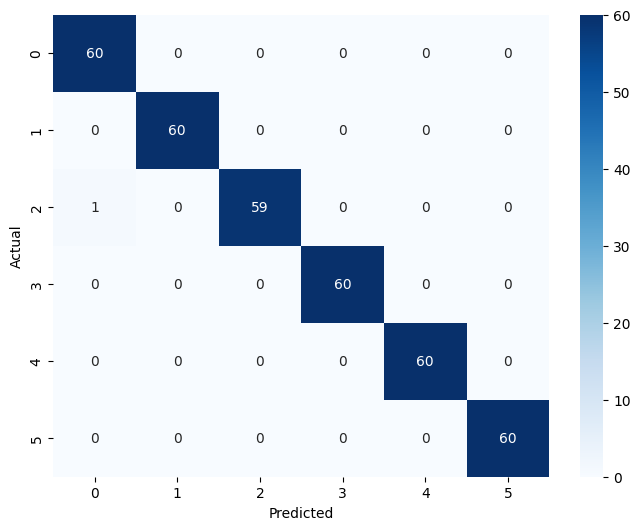

                 precision    recall  f1-score   support

        crazing       0.98      1.00      0.99        60
      inclusion       1.00      1.00      1.00        60
        patches       1.00      0.98      0.99        60
 pitted_surface       1.00      1.00      1.00        60
rolled-in_scale       1.00      1.00      1.00        60
      scratches       1.00      1.00      1.00        60

       accuracy                           1.00       360
      macro avg       1.00      1.00      1.00       360
   weighted avg       1.00      1.00      1.00       360



In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
class_names = [
    "crazing",
    "inclusion",
    "patches",
    "pitted_surface",
    "rolled-in_scale",
    "scratches"
]

print(classification_report(y_true, y_pred, target_names=class_names))

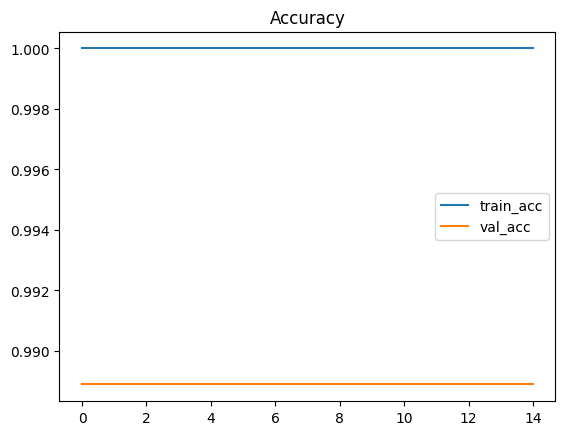

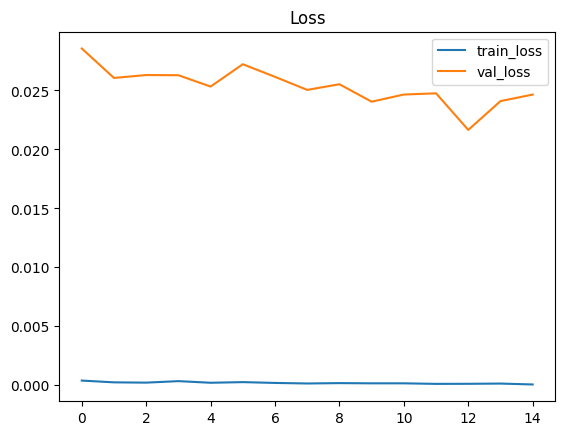

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()